# Action recognition in still images

## 实验流程
1. 通过yolo v3检测手的存在；
2. 如果存在手则截取手部区域成(300, 300, 3)的图片；
3. 利用ActNet(动作分类器)对手部的动作进行分类，得到action的表达；
4. 利用yolo v3检测手周围的物体，获得object的表达；
5. 输出最终结果。


* 由于时间原因仅选取了3个动作 [cut, wash, take]
* 现在用到两次yolo v3检测，但是在后续的过程中会把物体识别和手部识别结合放到一起训练

In [49]:
import matplotlib.pyplot as plt
from IPython.display import Image
import shutil
import torch
import cv2
%cd yolov3

In [2]:
# 解决openMP冲突
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

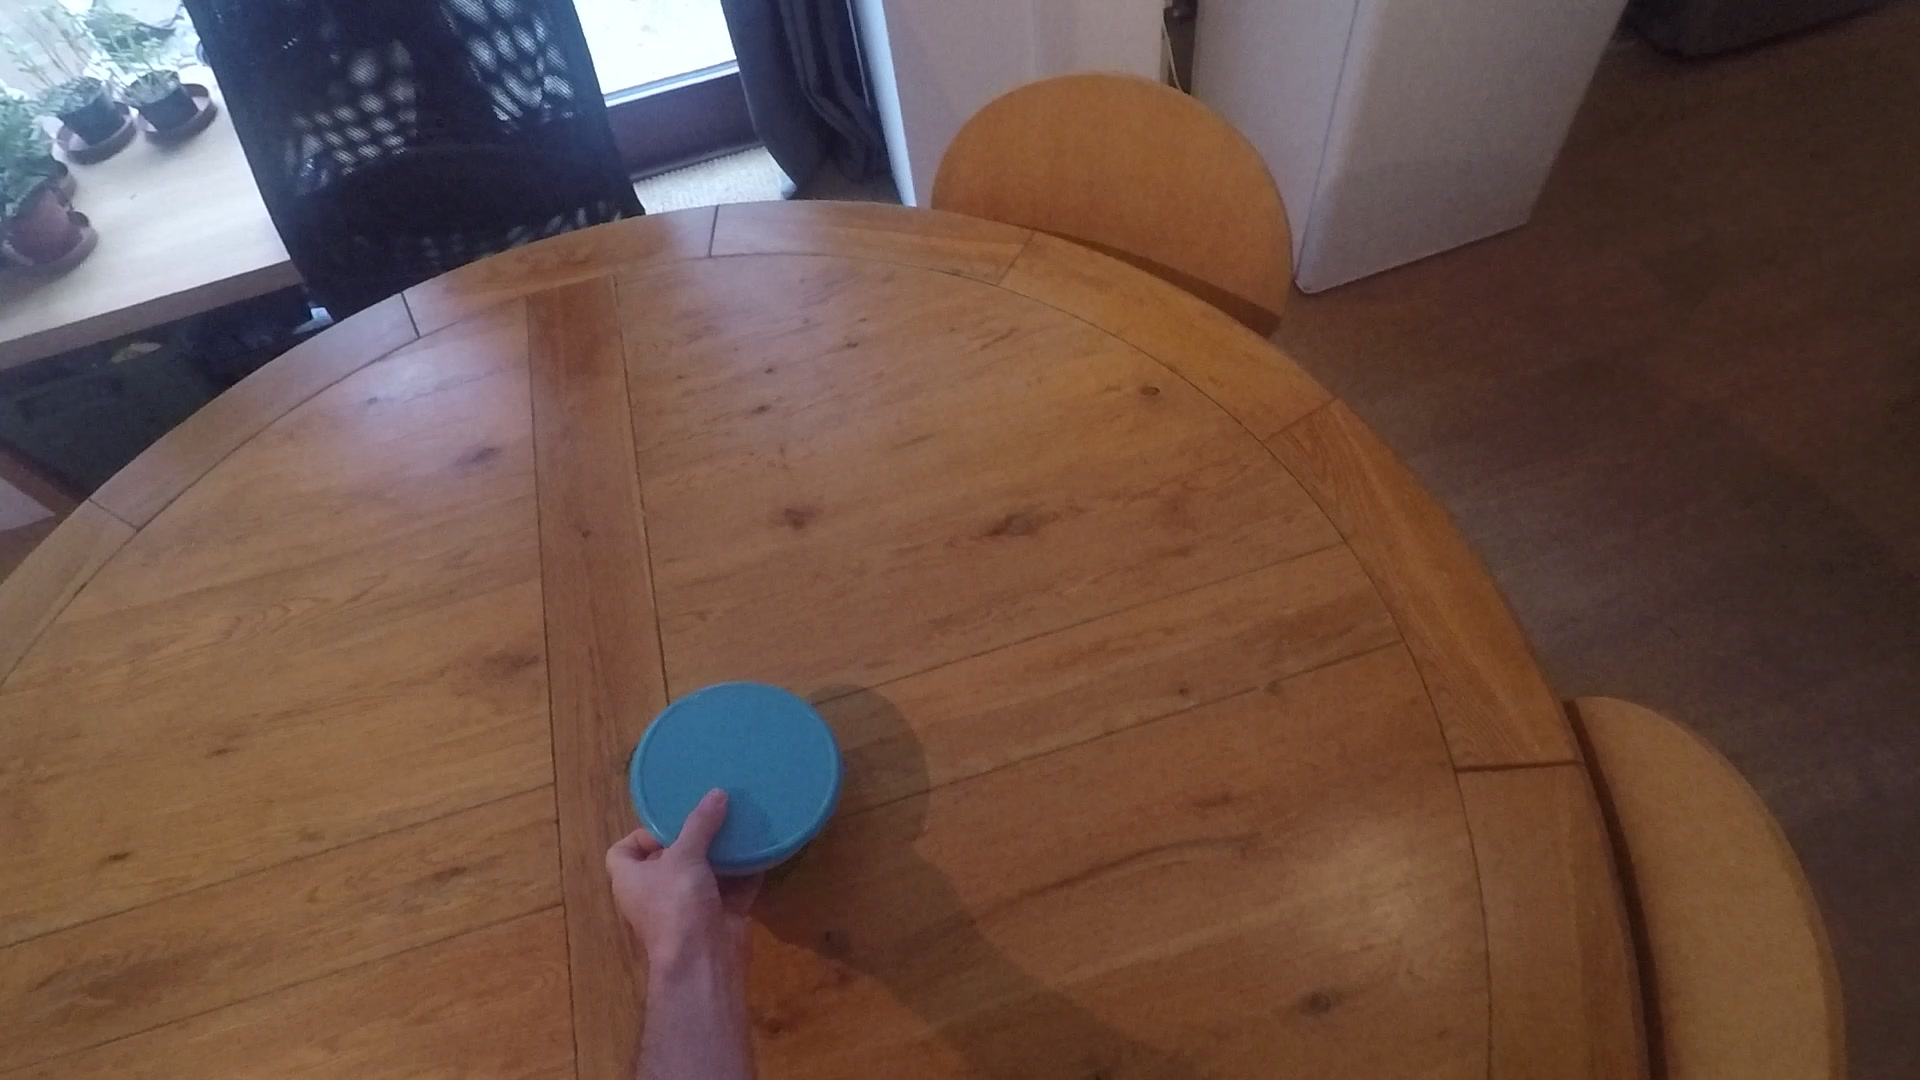

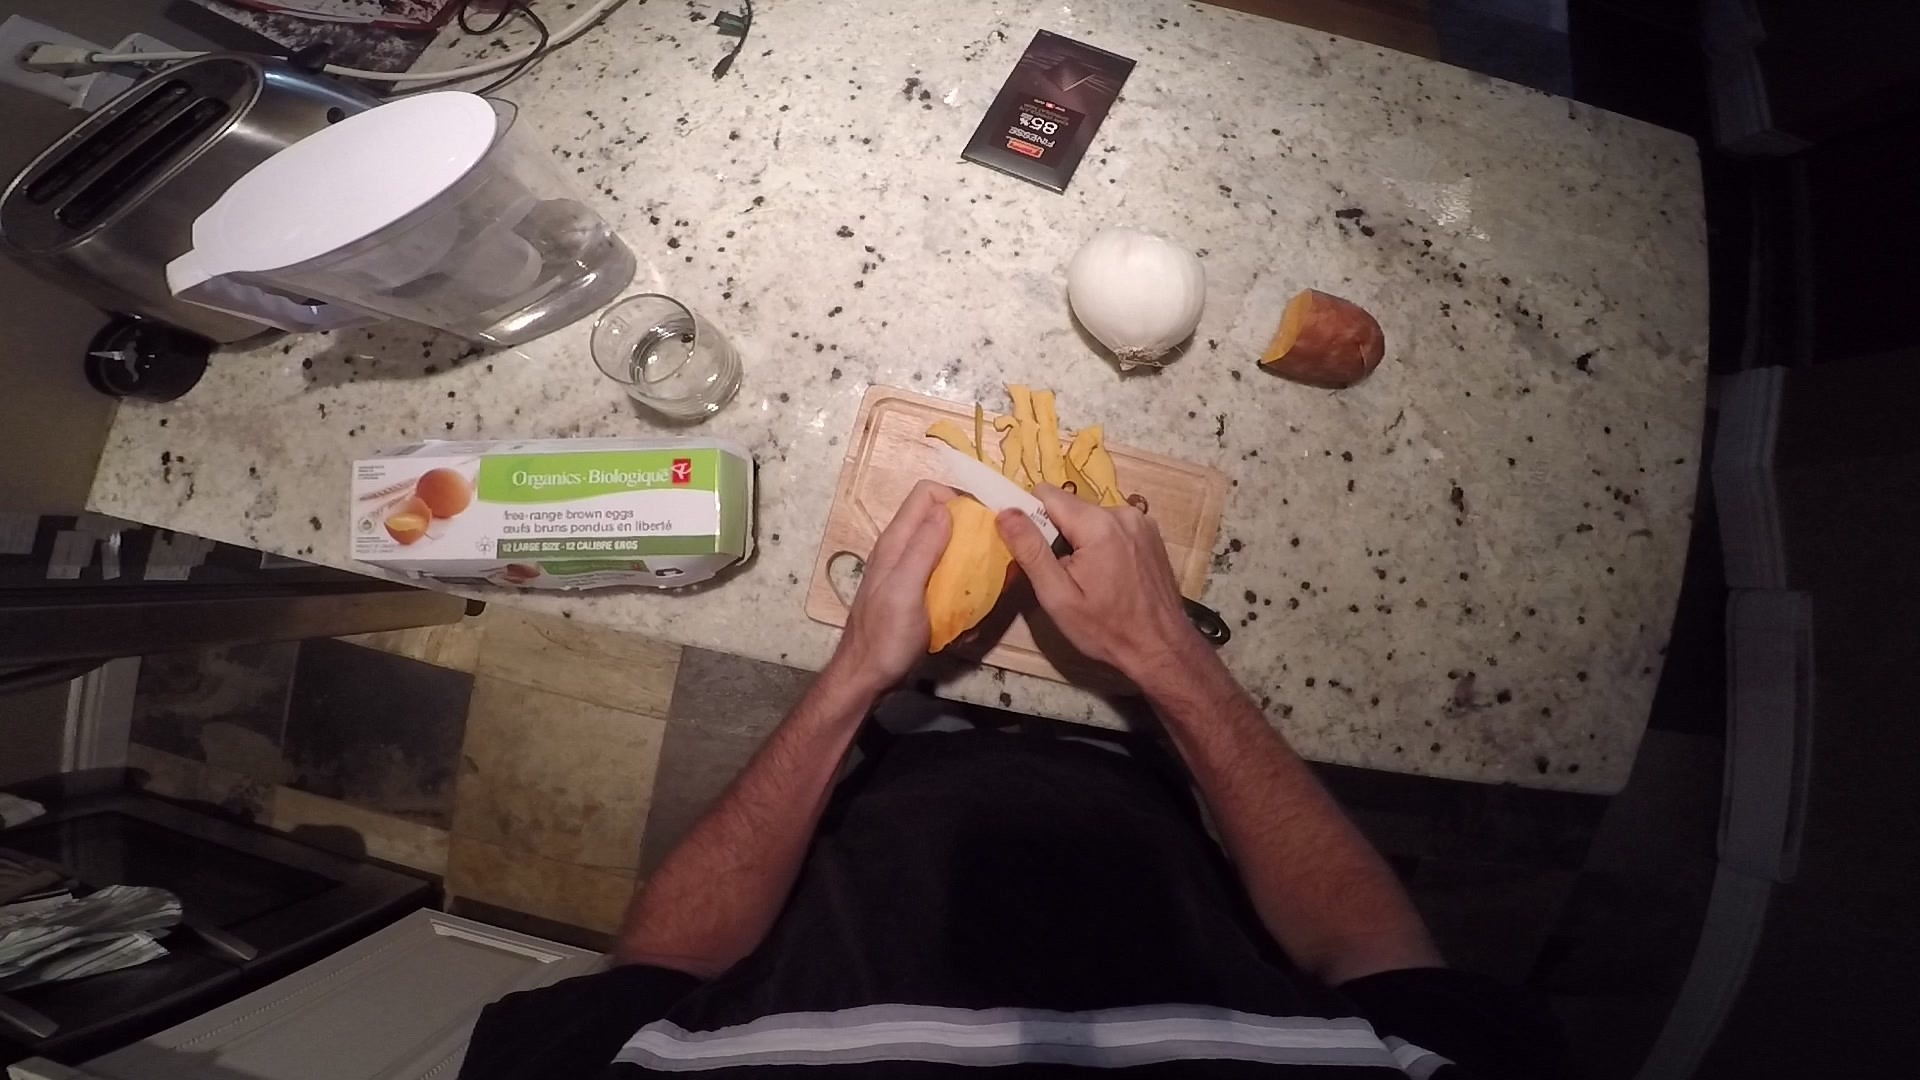

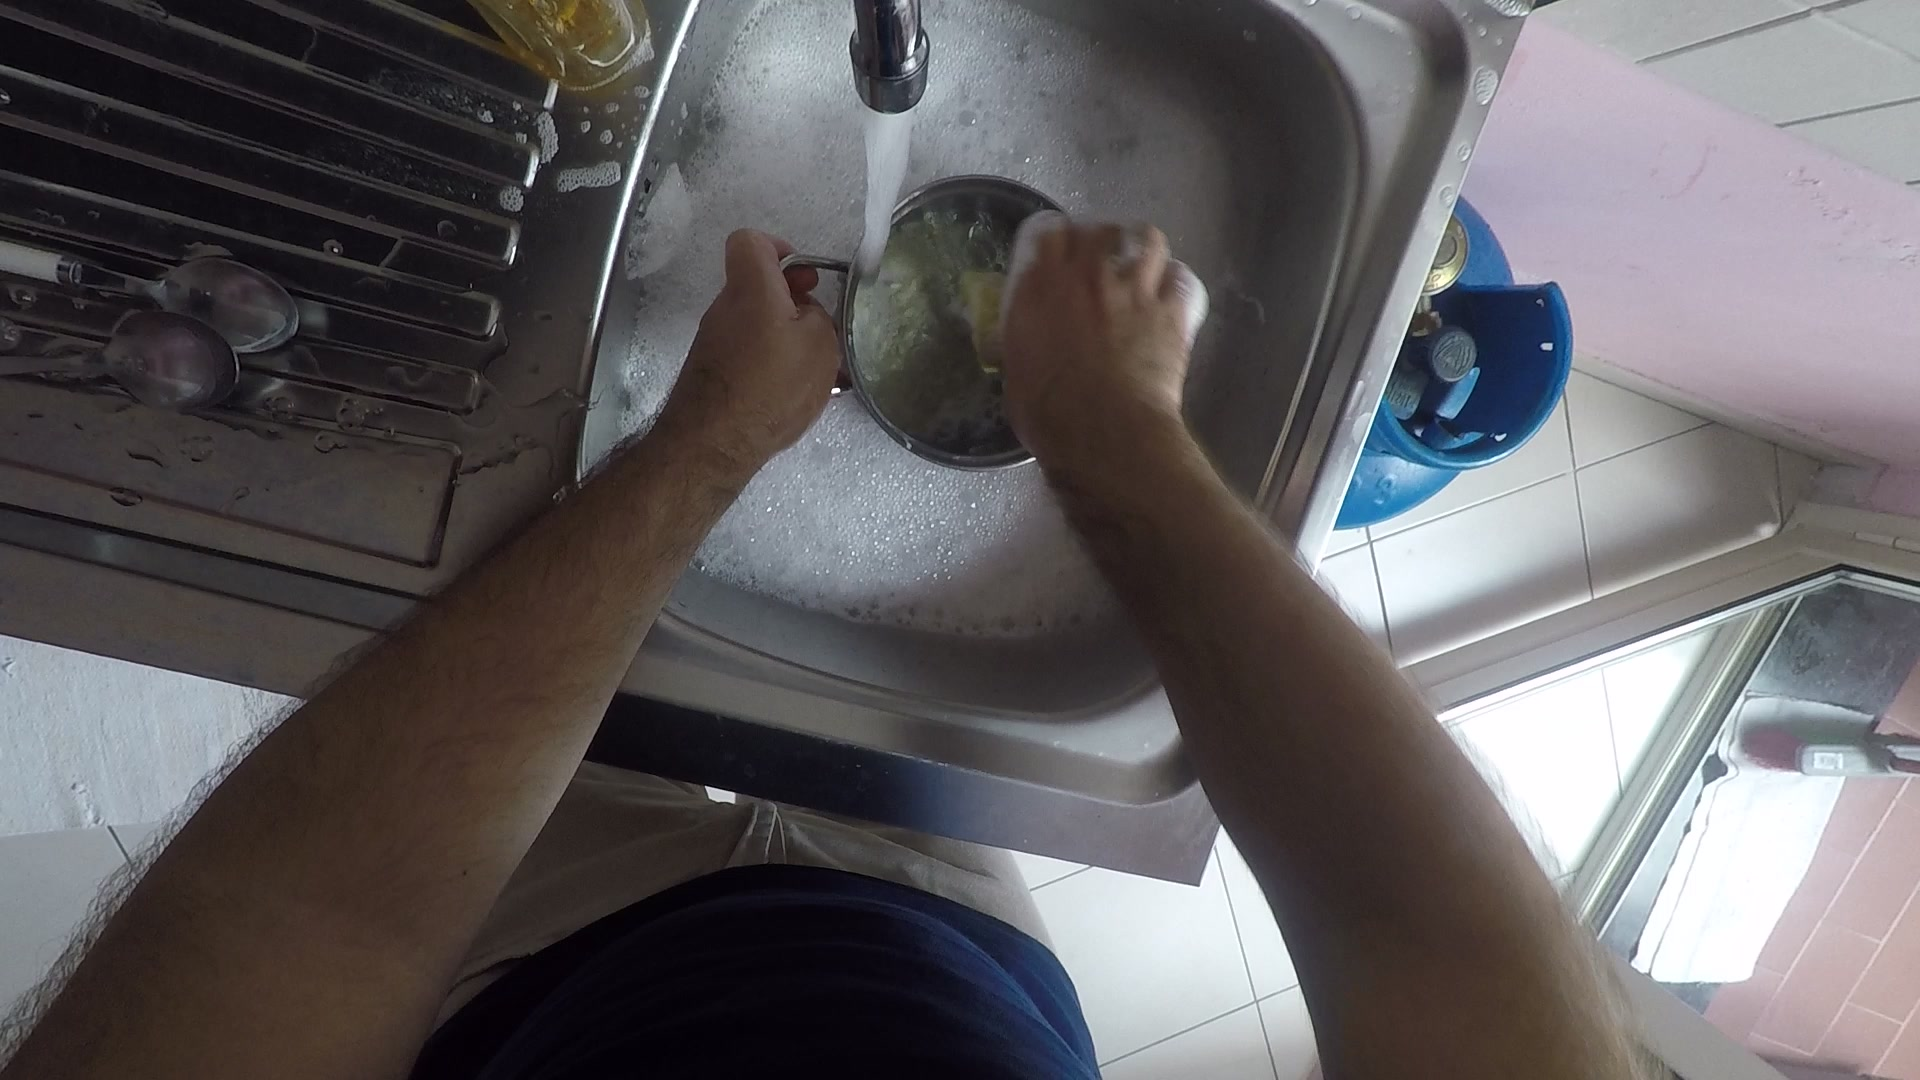

In [3]:
# 查看待检测原图
display(Image('./data/samples/P01_P01_04_0000006061.jpg'))
display(Image('./data/samples/P15_P15_01_0000008251.jpg'))
display(Image('./data/samples/P25_P25_02_0000012871.jpg'))

In [60]:
# 检测手
!python detect.py --cfg 'cfg/yolov3-hands.cfg' --names 'data/hands.names' --weights weights/best-hands-100.pt --img-size 416 --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hands.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='data/hands.names', output='output', save_txt=True, source='data/samples', view_img=False, weights='weights/best-hands-100.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/3 data/samples/P01_P01_04_0000006061.jpg: 288x416 1 hands, Done. (0.737s)
image 2/3 data/samples/P15_P15_01_0000008251.jpg: 288x416 2 hands, Done. (0.655s)
image 3/3 data/samples/P25_P25_02_0000012871.jpg: 288x416 2 hands, Done. (0.710s)
Results saved to /Users/aaron/Desktop/code/dissertation-diary/yolov3/output
Done. (2.601s)


In [61]:
# 记录手的位置
hands_boxes = []
files = os.listdir('output')
for file in files:
    if file.endswith('.txt'):
        with open(os.path.join('output', file), 'r') as f:
            lines = f.readlines()
        lines = [x.strip().split(' ') for x in lines]        
        hands_boxes.append(lines)

for i in range(len(hands_boxes)):
    print(hands_boxes[i])

[['0', '0.352604', '0.822222', '0.071875', '0.159259']]
[['0', '0.570833', '0.525463', '0.107292', '0.193519'], ['0', '0.473177', '0.546759', '0.0848958', '0.182407']]
[['0', '0.396875', '0.311111', '0.104167', '0.222222'], ['0', '0.571094', '0.310185', '0.117188', '0.233333']]


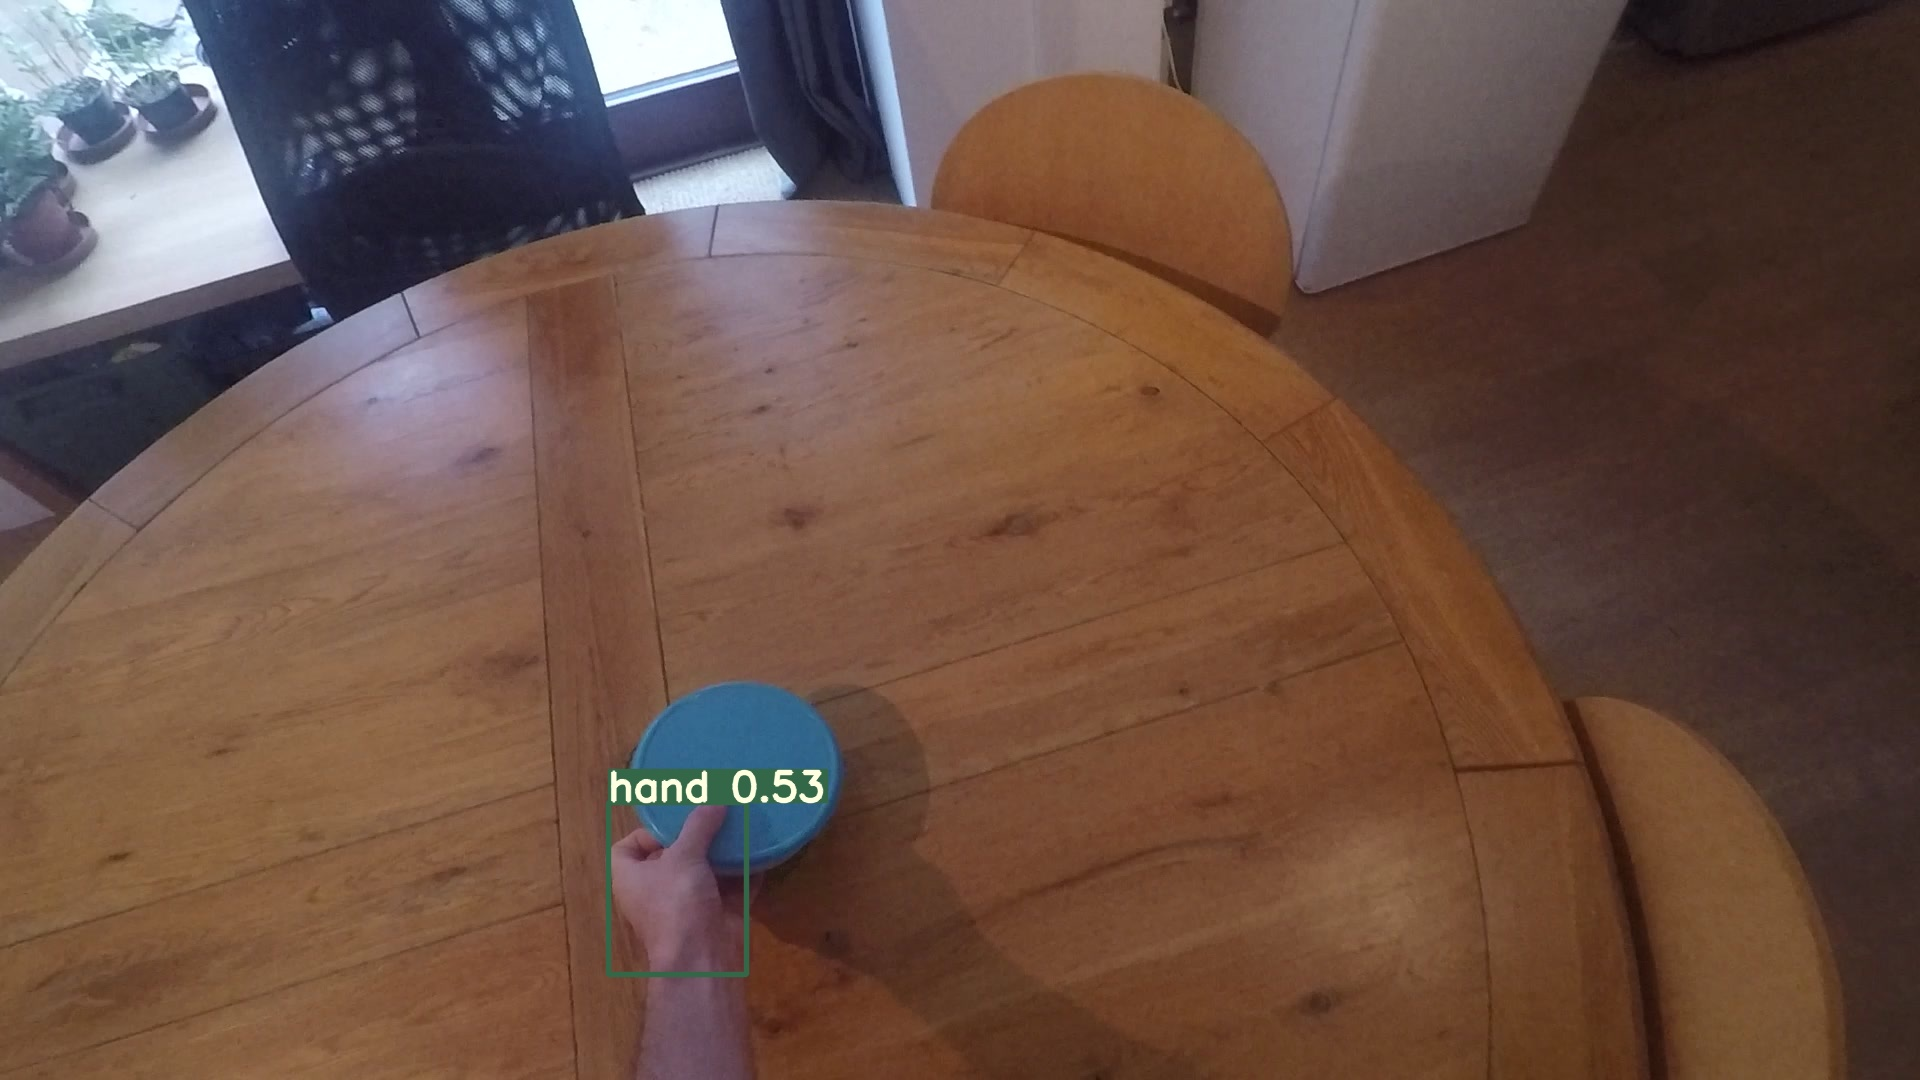

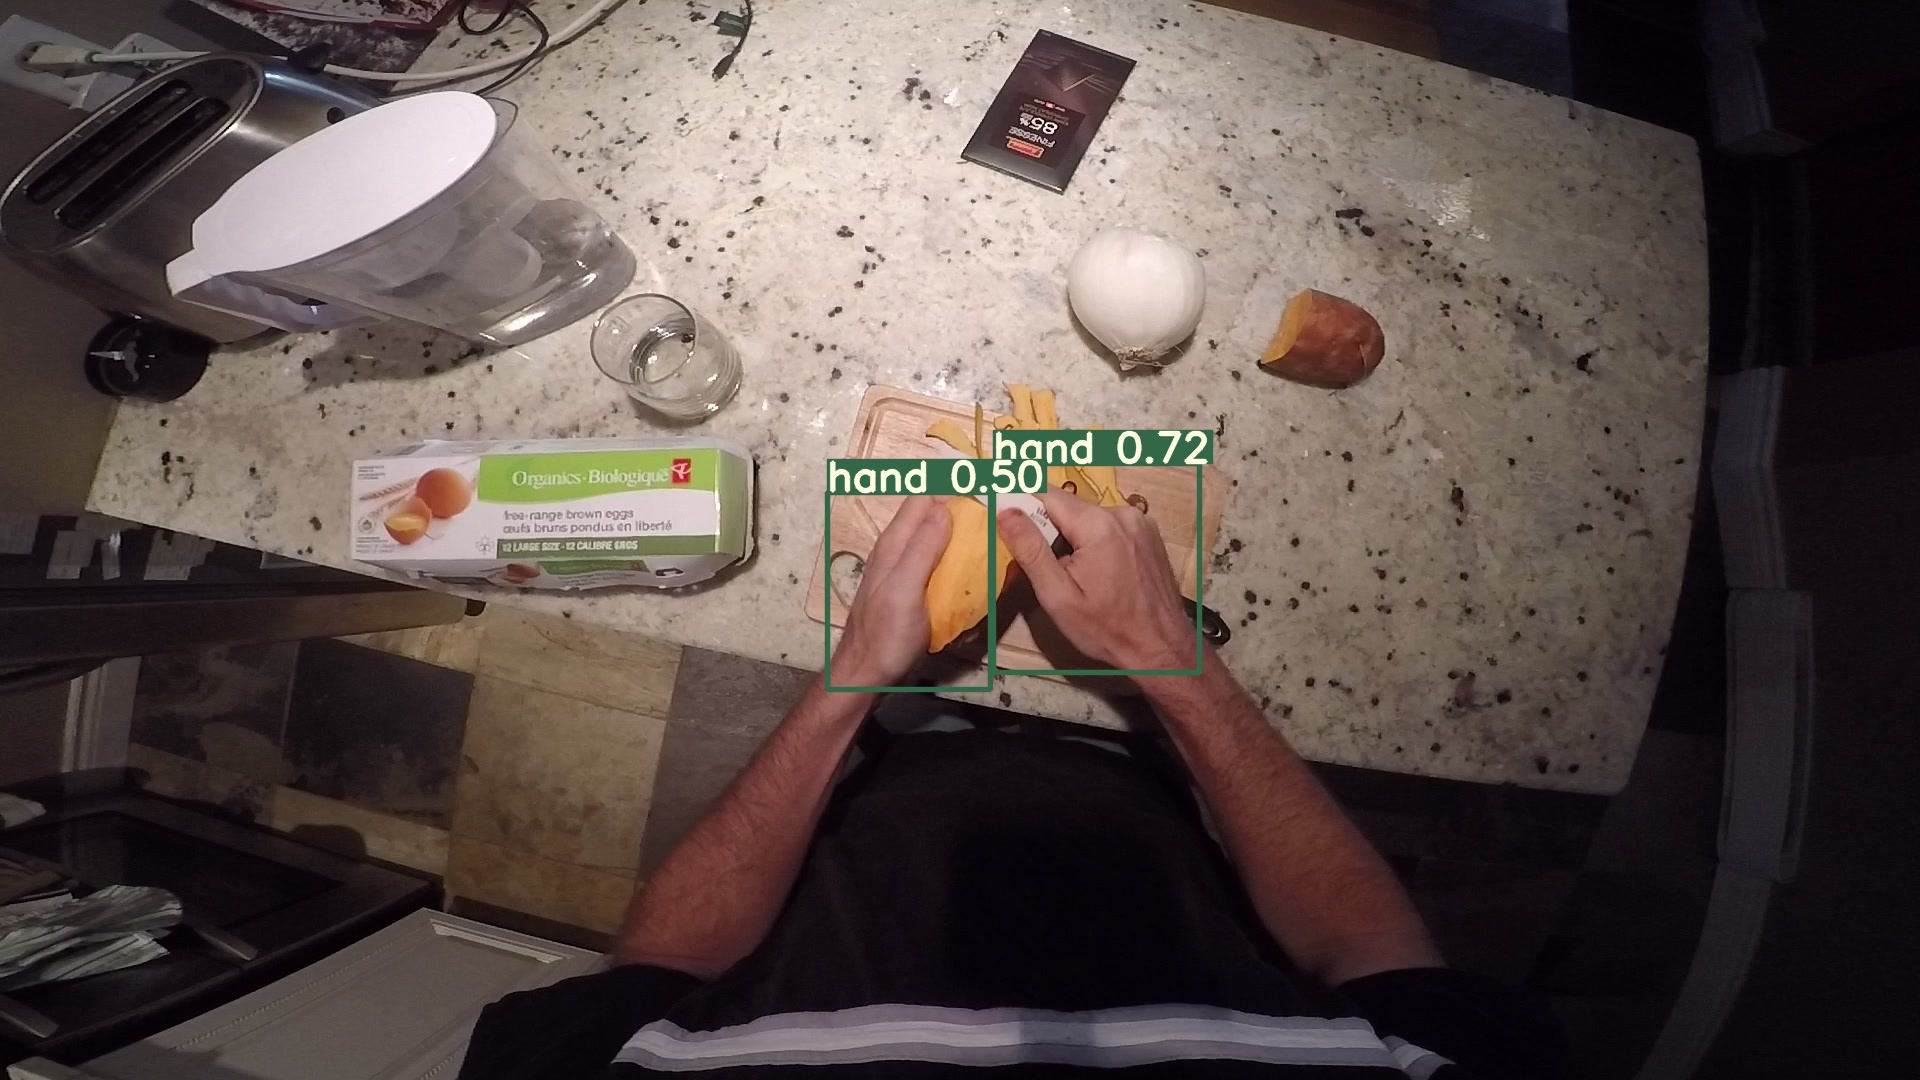

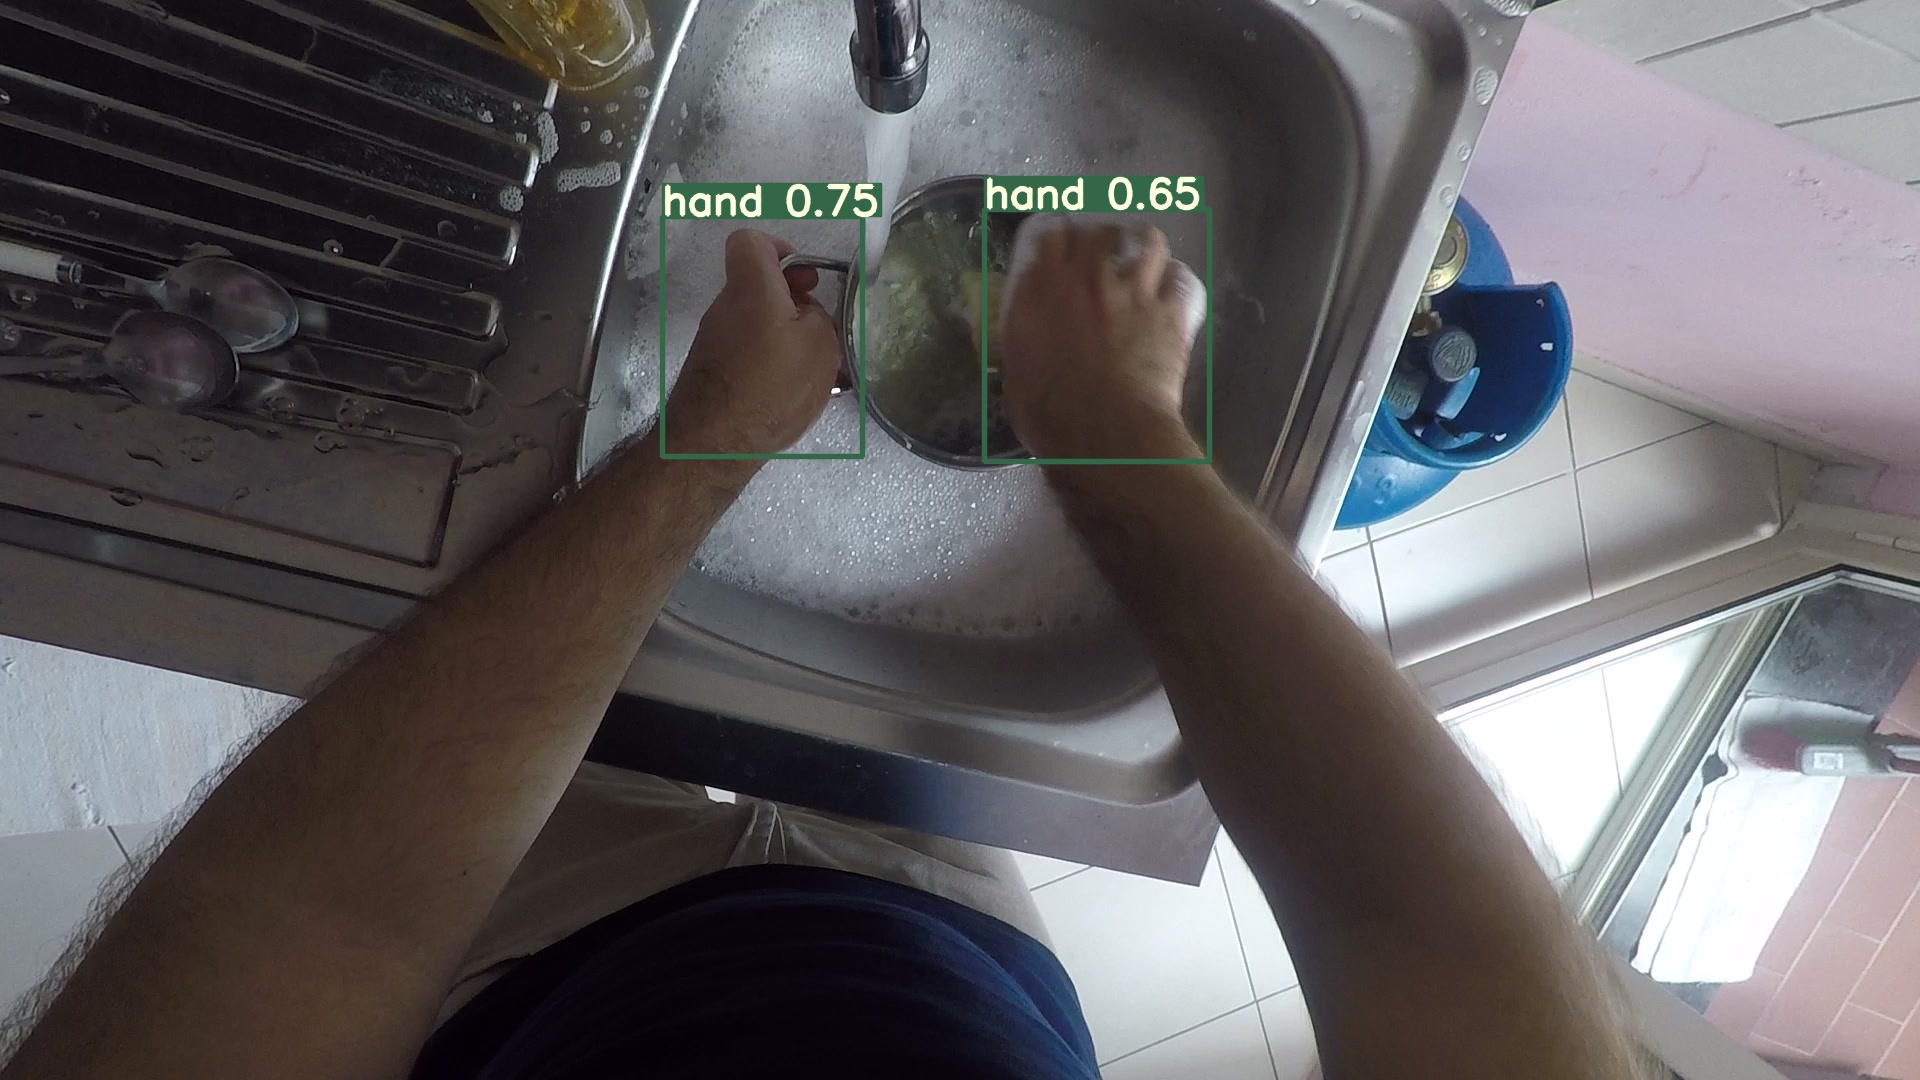

In [38]:
display(Image('./output/P01_P01_04_0000006061.jpg'))
display(Image('./output/P15_P15_01_0000008251.jpg'))
display(Image('./output/P25_P25_02_0000012871.jpg'))

In [39]:
cd ..

/Users/aaron/Desktop/code/dissertation-diary


In [7]:
# 根据检测输出的坐标裁剪手部区域
%run crop_img.py --img_path 'yolov3/data/samples' --label_path 'yolov3/output' --iou_thres -1 --save_name 'crop' --out_dir 'hands_action_crop'

100%|██████████| 4/4 [00:00<00:00, 47.10it/s]

Namespace(img_path='yolov3/data/samples', iou_thres=-1.0, label_path='yolov3/output', out_dir='hands_action_crop', out_size=300, save_name='crop', scope=100)


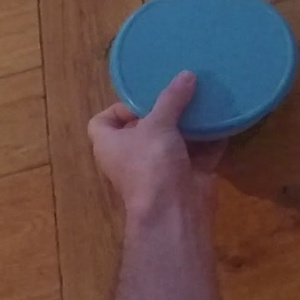

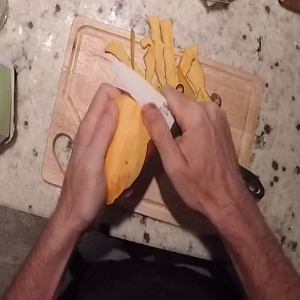

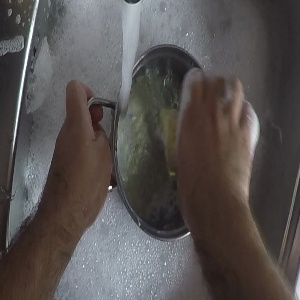

In [8]:
display(Image('hands_action_crop/crop_P01_P01_04_0000006061.jpg'))
display(Image('hands_action_crop/crop_P15_P15_01_0000008251.jpg'))
display(Image('hands_action_crop/crop_P25_P25_02_0000012871.jpg'))

In [9]:
shutil.copy('hands_action_crop/crop_P01_P01_04_0000006061.jpg', './action-detection/data/samples')
shutil.copy('hands_action_crop/crop_P15_P15_01_0000008251.jpg', './action-detection/data/samples')
shutil.copy('hands_action_crop/crop_P25_P25_02_0000012871.jpg', './action-detection/data/samples')
%cd action-detection

/Users/aaron/Desktop/code/dissertation-diary/action-detection


In [10]:
# 动作检测
!python detection.py --weights 'weights/best-0.0001-99epoch.pt' --source 'data/samples'

Namespace(names='data/action.names', out='output', source='data/samples', weights='weights/best-0.0001-99epoch.pt')
Saving image:  crop_P01_P01_04_0000006061.jpg ---> prediction:  take

Saving image:  crop_P15_P15_01_0000008251.jpg ---> prediction:  cut

Saving image:  crop_P25_P25_02_0000012871.jpg ---> prediction:  wash



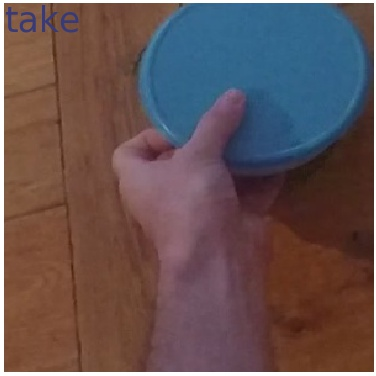

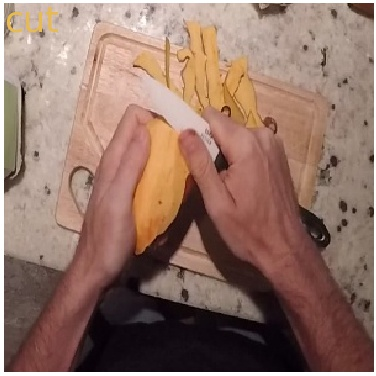

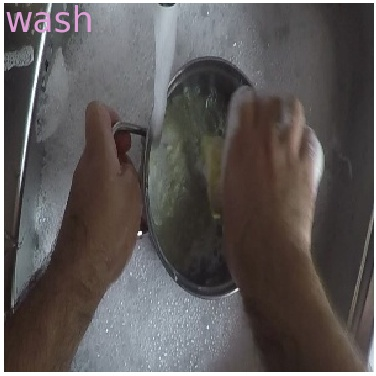

In [11]:
display(Image('output/crop_P01_P01_04_0000006061.jpg'))
display(Image('output/crop_P15_P15_01_0000008251.jpg'))
display(Image('output/crop_P25_P25_02_0000012871.jpg'))

In [42]:
cd ../yolov3/

/Users/aaron/Desktop/code/dissertation-diary/yolov3


In [43]:
# 物体检测
!python detect.py --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/coco.names', output='output', save_txt=True, source='data/samples', view_img=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CPU

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/3 data/samples/P01_P01_04_0000006061.jpg: 320x512 1 persons, 1 frisbees, 1 oranges, 2 chairs, 1 dining tables, Done. (1.033s)
image 2/3 data/samples/P15_P15_01_0000008251.jpg: 320x512 1 persons, 1 books, Done. (1.177s)
image 3/3 data/samples/P25_P25_02_0000012871.jpg: 320x512 1 persons, 1 bowls, Done. (0.970s)
Results saved to /Users/aaron/Desktop/code/dissertation-diary/yolov3/output
Done. (3.662s)


In [59]:
# 记录物体的位置
obj_boxes = []
files = os.listdir('output')
for file in files:
    if file.endswith('.txt'):
        with open(os.path.join('output', file), 'r') as f:
            lines = f.readlines()
        lines = [x.strip().split(' ') for x in lines]
#         for i in range(len(lines)):
#             lines[i] = [float(x) for x in lines[i]]
        obj_boxes.append(lines)
for i in range(len(hands_boxes)):
    print(hands_boxes[i])

[['29', '0.383333', '0.718056', '0.109375', '0.176852'], ['0', '0.35625', '0.864352', '0.0833333', '0.265741'], ['60', '0.473958', '0.580093', '0.921875', '0.813889'], ['56', '0.28151', '0.152315', '0.365104', '0.300926'], ['49', '0.579687', '0.187037', '0.183333', '0.25'], ['56', '0.578385', '0.189352', '0.191146', '0.249074']]
[['0', '0.529167', '0.708796', '0.56875', '0.565741'], ['73', '0.546354', '0.105093', '0.0947917', '0.156481']]
[['0', '0.409115', '0.570833', '0.814062', '0.84537'], ['45', '0.496094', '0.302778', '0.113021', '0.255556']]


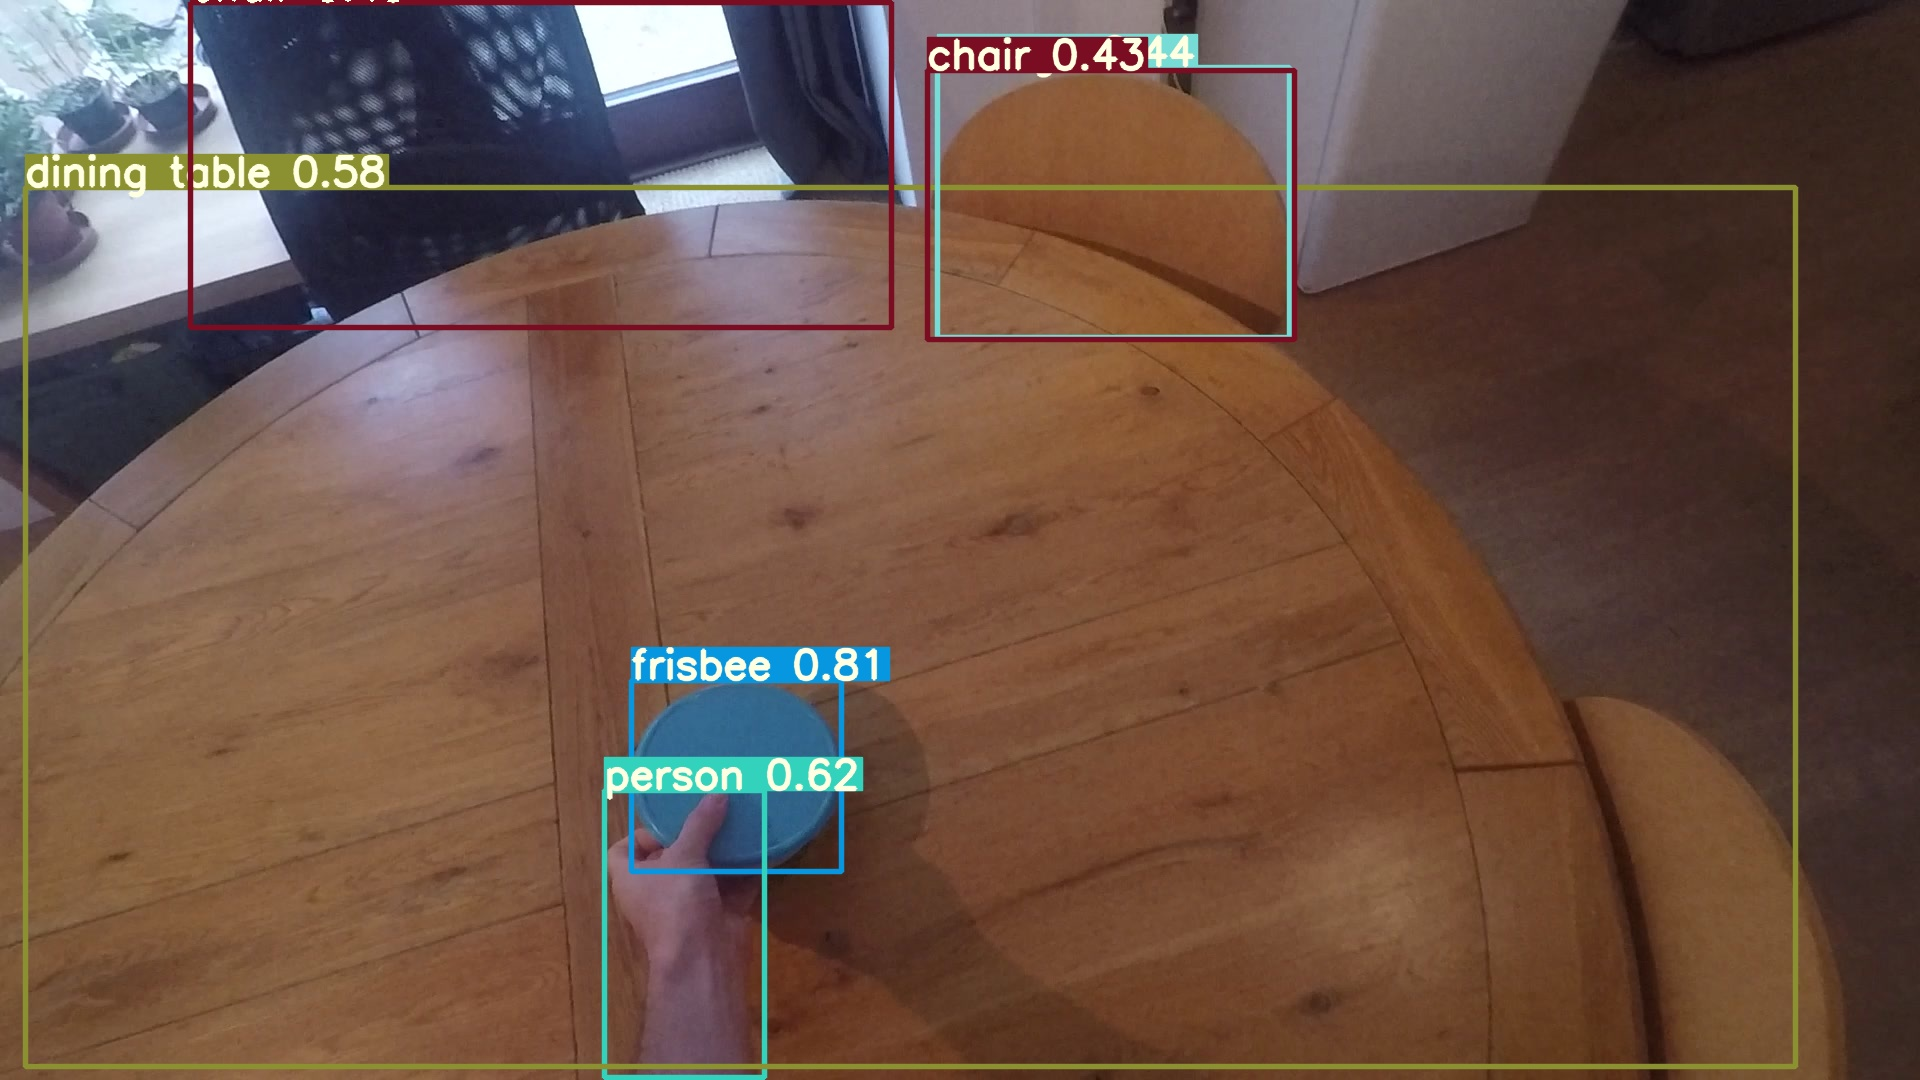

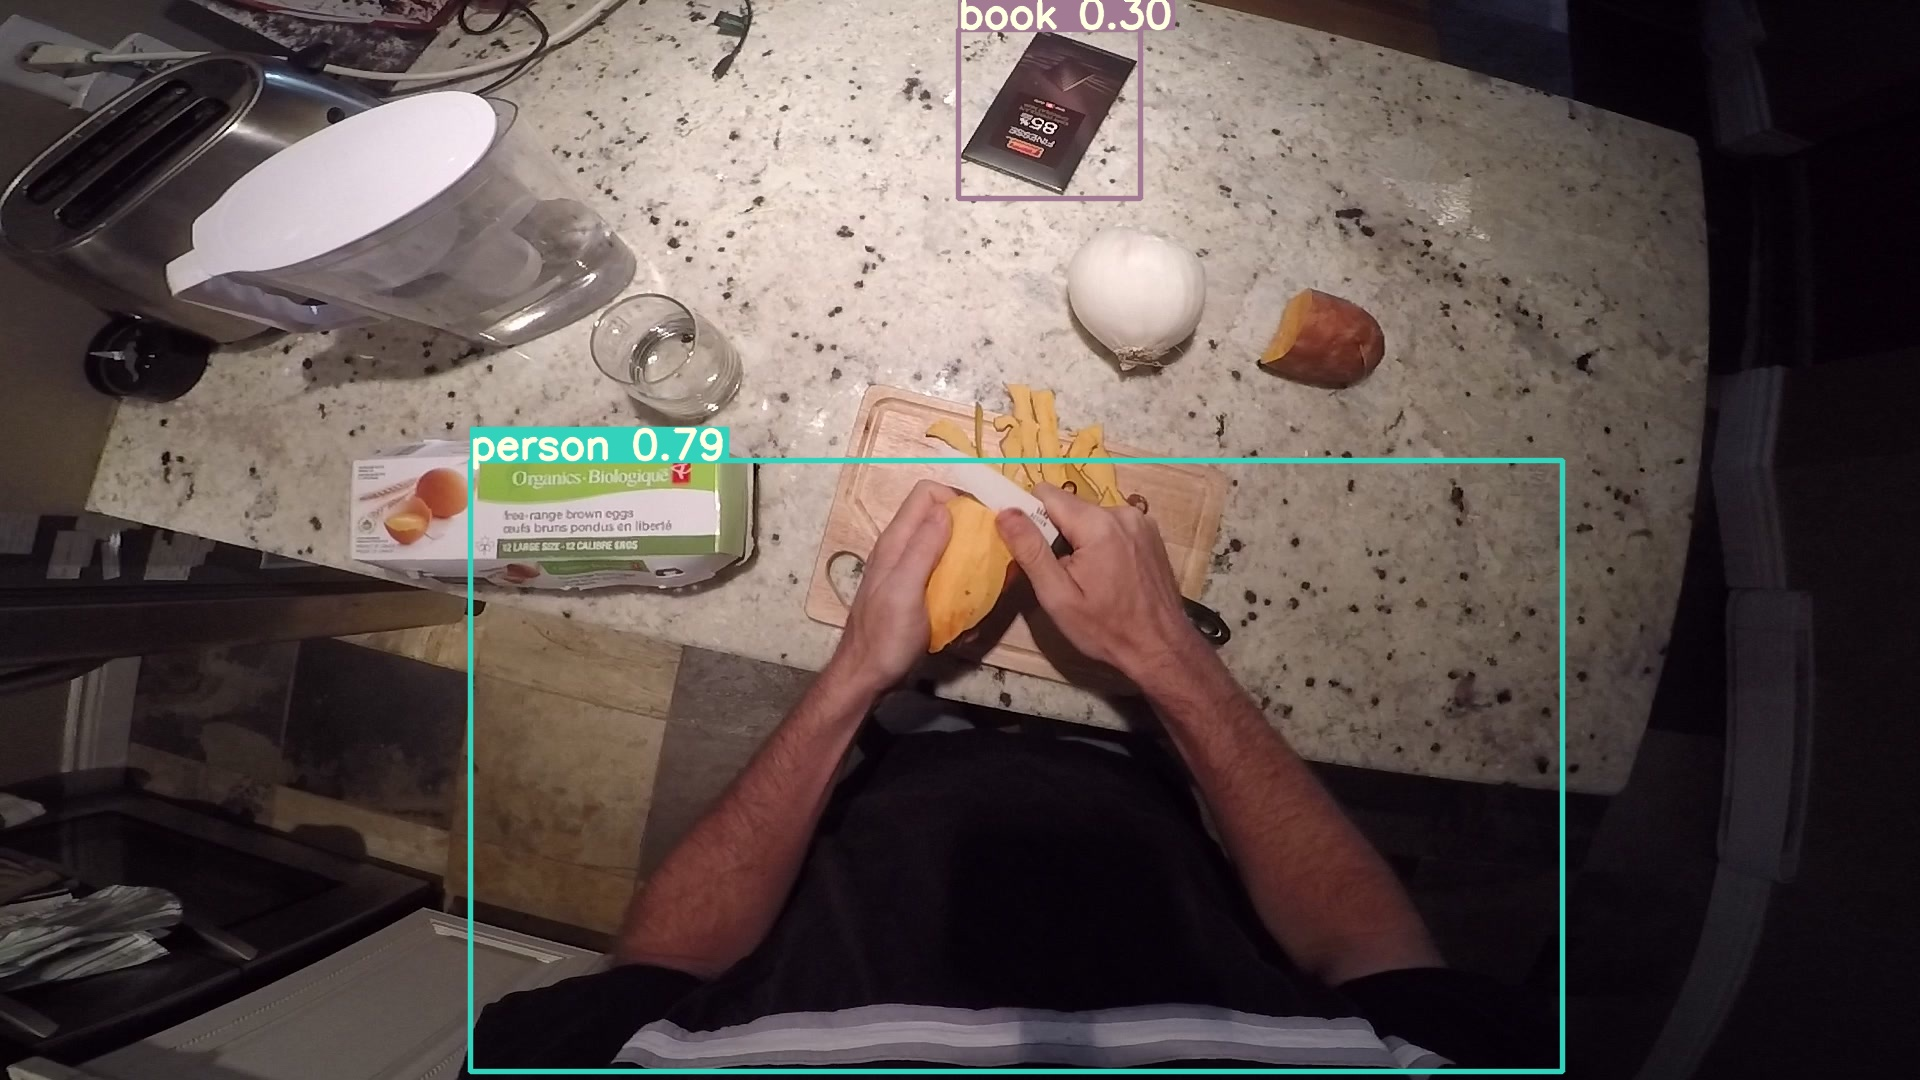

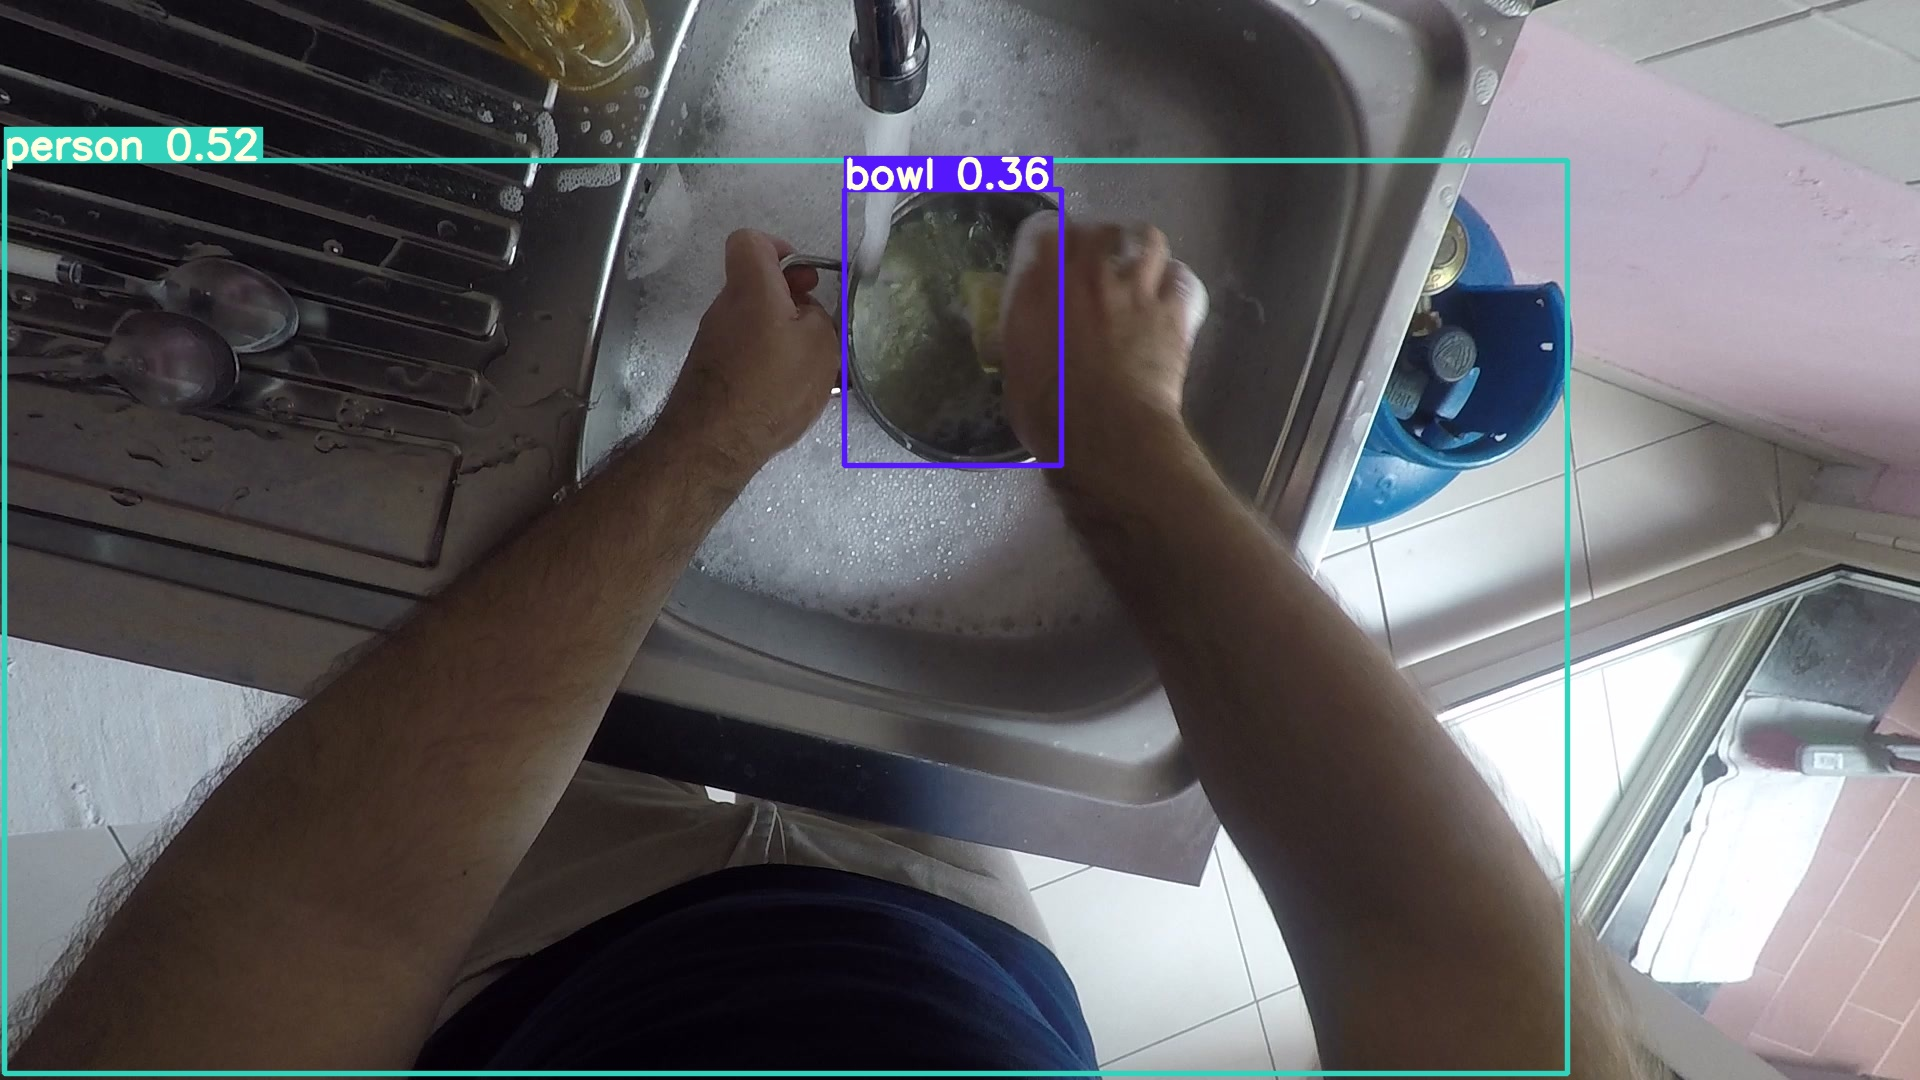

In [17]:
display(Image('output/P01_P01_04_0000006061.jpg'))
display(Image('output/P15_P15_01_0000008251.jpg'))
display(Image('output/P25_P25_02_0000012871.jpg'))

In [19]:
# get object names
with open('data/coco.names', 'r') as f:
    obj_names = f.readlines()
obj_names = [x.strip() for x in obj_names]
print(obj_names)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [22]:
# get action names
with open('../action-detection/data/action.names', 'r') as f:
    act_names = f.readlines()
act_names = [x.strip() for x in act_names]
print(act_names)

['take', 'cut', 'wash']


* 接下来的话通过计算手和物体的IoU确定交互的主体（我们认为IoU>0才是交互，也可设定为更大的阈值）。最后得出来的结果应该是\< action \> \< object \>的格式。